In [2]:
#allow file access
from google.colab import files

from tensorflow.keras.models import load_model

import pickle

#import shap  
#import shap
#shap.initjs()

import pandas as pd
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior() #this was required for SHAP values
from tensorflow import keras


tf.compat.v1.enable_eager_execution() #required for mse losses

#borrowed form 5c16
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from keras.models import model_from_json

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

#r2 score
from keras import backend as K
from sklearn.metrics import r2_score

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

In [3]:
ch_names = np.arange(44).tolist()
freqs = np.arange(191.6, 195.9, 0.1).tolist()
for x in range(len(ch_names)):
  ch_names[x] = "Ch %.0f (%.1f)" % (ch_names[x], freqs[x])

In [4]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('r_squared'))
        self.val_acc.append(logs.get('val_r_squared'))

        
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(24, 12))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('MSE')
        plt.xlabel('epoch')
        plt.title('Mean Squared Error')
        plt.legend()
        plt.subplot(122)         
        plt.plot(self.x, self.acc, label="training r-squared")
        plt.plot(self.x, self.val_acc, label="validation r-squared")
        plt.legend()
        plt.ylabel('R-squared')
        plt.xlabel('epoch')
        plt.title('R-Squared Value')
        
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        

#creating a r^2 metric for the model evaluation
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

    

In [5]:
#generate the train and testing datasets
#retreiving both datasets from GitHub
git_xval = 'https://raw.githubusercontent.com/p-owens/MAI/main/x_val.csv'
git_yval = 'https://raw.githubusercontent.com/p-owens/MAI/main/y_val.csv'
df0 = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names)

df1 = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names)

#convert to numpy
x_values = df0.to_numpy()
y_values = df1.to_numpy()

#removing the frequency row - treating these values as labels
x_values = x_values[1::2,:]

#generate the test/validation split
#x_rem, x_test, y_rem, y_test = skl.model_selection.train_test_split(x_values, y_values, test_size=.2, random_state=0)
x_train, x_val, y_train, y_val = skl.model_selection.train_test_split(x_values, y_values, test_size=.2, random_state=0)#renaimed x_rem and y_rem to x_values and y_values

In [ ]:
#create the models
inputs = keras.layers.Input(shape=(44,))


x = Dense(1056, activation='relu')(inputs)
x = Dropout(0.45)(x) # Drop out
x = Dense(1056, activation='linear')(x)
x = Dropout(0.45)(x) # Drop out
x = Dense(1056, activation='relu')(x)
x = Dropout(0.45)(x) # Drop out random 2% to prevent overfitting
x = Dense(528, activation='linear')(x)
x = Dropout(0.45)(x) # Drop out
predictions = Dense(44, activation='relu')(x)



# we create the model 
model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = tf.keras.optimizers.Nadam(learning_rate=0.000 04)

# setup the optimisation strategy
model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=[r_squared]) #tf.keras.metrics.MeanAbsoluteError()


model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1056)              47520     
_________________________________________________________________
dropout_16 (Dropout)         (None, 1056)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1056)              1116192   
_________________________________________________________________
dropout_17 (Dropout)         (None, 1056)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 1056)              1116192   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1056)              0   

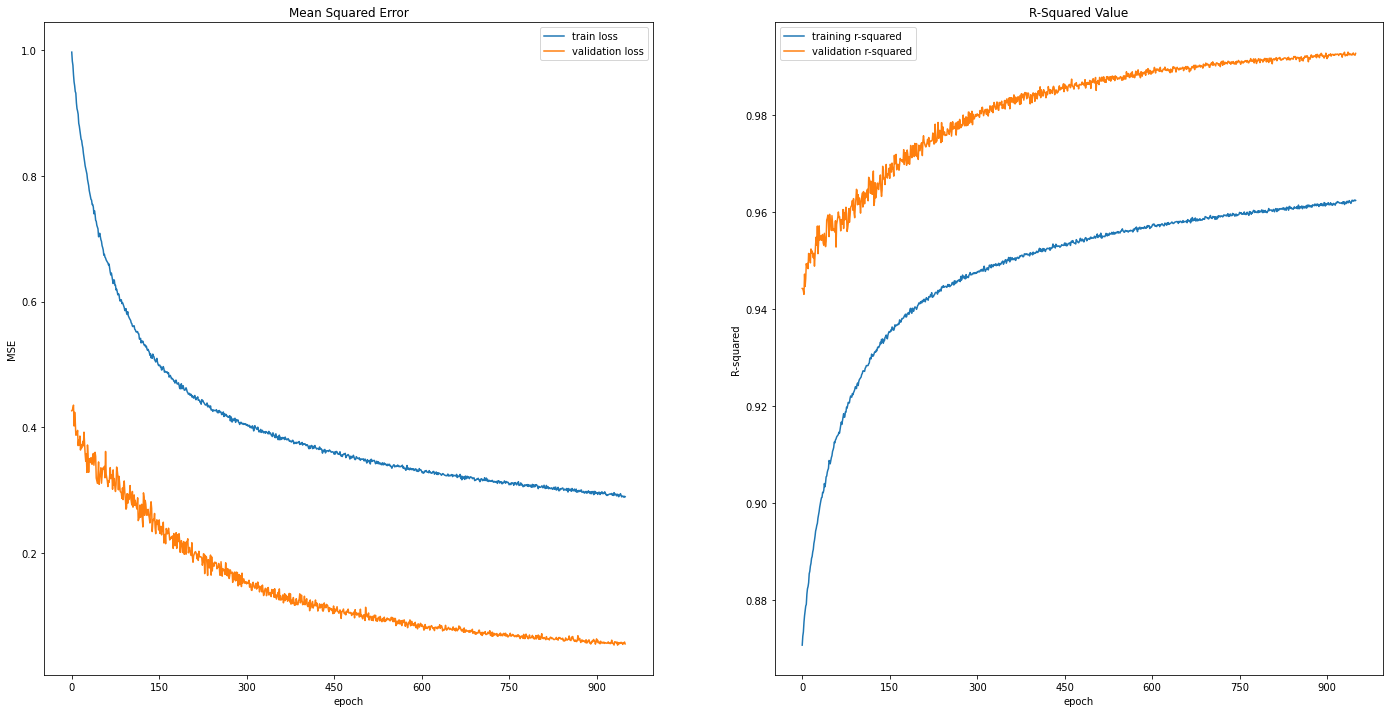


Epoch 00950: val_loss did not improve from 0.05363
9577/9577 [==============================] - 1s 53us/sample - loss: 0.2898 - r_squared: 0.9624 - val_loss: 0.0556 - val_r_squared: 0.9928


In [ ]:
#callback for plotting the model metrics


csv_log = CSVLogger(log_file)
pltCallBack = PlotLossAccuracy()
#callback for saving the model
checkpoint = ModelCheckpoint(filepath='ep_{epoch:02d}_mse_{val_loss:.2f}_r2_{val_r_squared:.2f}.hdf5',
                             monitor='val_loss',
                             verbose=1,
                             save_weights_only=False,
                             save_best_only=True,
                             mode='min',
                             save_freq="epoch")

# and train
model.fit(x_train, y_train,
                    batch_size=512, epochs=950, 
                    validation_data=(x_val, y_val), 
                    callbacks=[pltCallBack, checkpoint, csv_log])

In [152]:
#set the channel number here
channel = 5

In [153]:
#Using a dataset with 1 ch constantly on for the test set
#retreiving both datasets from GitHub



git_xval = ('https://raw.githubusercontent.com/p-owens/MAI/main/data%20gen/ch{0}/x_val.csv'.format(channel))
git_yval = ('https://raw.githubusercontent.com/p-owens/MAI/main/data%20gen/ch{0}/y_val.csv'.format(channel))
dfx = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names                                   
                 )
dfy = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names
                 )
x_test = dfx.to_numpy()
y_test = dfy.to_numpy()

#removing the frequency row - treating these values as labels
x_test = x_test[1::2,:]

In [154]:
dfx = dfx.iloc[1::2]
df_chx = dfx[dfx[ch_names[channel]] !=0].iloc[:,:]
df_chy = dfy[dfy[ch_names[channel]] !=0].iloc[:,:]
#df_chy = df_chy[ch_names[channel]]


x_test = df_chx.to_numpy()
y_test = df_chy.to_numpy()

In [149]:
#evaluate the model on the test set
results = model.evaluate(x_test,y_test, verbose=1)
print("{name1}\t\t: {mse:<.4f}\t(lower is better)\n{name2}\t: {r2:<.2%}\t(higher is better)".format(name1 = model.metrics_names[0], name2 = model.metrics_names[1],mse = results[0],r2 = results[1]))

7/7 [==============================] - 0s 8ms/step - loss: 0.0561 - r_squared: 0.9929
loss		: 0.0561	(lower is better)
r_squared	: 99.29%	(higher is better)


In [150]:
mape = tf.keras.metrics.MeanAbsolutePercentageError()
#print(mse(y_test[5], model.predict(x_test)[5]))


In [155]:

mape.update_state([y_test[:,channel]], [model.predict(x_test)[:,channel]]).numpy()
mape.result().numpy()

12.62027

In [ ]:
y_test[:,11]

In [ ]:
pd.DataFrame([y_test[:,11],
model.predict(x_test)[:,11]])#, np.transpose(sq_err))

In [ ]:
pd.DataFrame([np.transpose(y_test[:,11], -1), np.transpose(model.predict(x_test)[:,11]), sq_err])

In [ ]:
checkpoint_dir = 'weights.97_0.32.h5'
latest = tf.train.latest_checkpoint(checkpoint_dir)
model_latest_checkpoint = create_model()# Load the previously saved weights
model_latest_checkpoint.load_weights(latest)
model_latest_checkpoint.summary()

In [7]:
#Load a previously saved model
model = tf.keras.models.load_model('ep_937_mse_0.05_r2_0.99.hdf5',
                                   custom_objects={'r_squared': r_squared},
                                   compile=True)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1056)              47520     
_________________________________________________________________
dropout_16 (Dropout)         (None, 1056)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1056)              1116192   
_________________________________________________________________
dropout_17 (Dropout)         (None, 1056)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 1056)              1116192   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1056)              0   